In [1]:
%pylab inline
plt.style.use("default")
import os, sys
import scipy
import random
import pandas as pd
import helpers as h
import utils as u
import matplotlib as mpl
from glob import glob
from scipy.io import loadmat
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

plt.rcParams['figure.figsize'] = (15, 10) 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def clean_unpack(data0):
    """returns clean and zscored signal"""
    resp0, spon0, istim0 = h.unbox(data0)

    resp0 = h.denoise_resp(resp0, spon0)

    resp0 = h.dupSignal(resp0, istim0)

    return resp0



In [4]:
def get_subpops(x, y, dx, dy, resp):
    inxs = []
    subpops = []
    xmax = x.max()
    ymax = y.max()
    Xrange = np.arange(xmax, step=dx)
    Yrange = np.arange(ymax, step=dy)
    for x0 in Xrange:
        for y0 in Yrange:
            x1 = x0+dx
            y1 = y0+dx
            inx = np.where(((x>x0) & (x<x1)) & ((y > y0) & (y < y1)))
            inxs.append(inx)
            subpop = resp[:, :, inx].squeeze(axis=2)
            subpops.append((((x0, x1), (y0, y1)), subpop))
    return subpops, inxs 

In [5]:
def compute_cvPCA(resp0, maxcols=69):
    ss0 = u.shuff_cvPCA(resp0, nshuff=10, maxcols=69)
    ss0 = ss0.mean(axis=0)
    ss0 = ss0 / ss0.sum()

    return ss0

In [6]:
data_root = "/Users/duuta/ppp/data/stringer/live_data/"
data_files = [fname.split("/")[-1] for fname in glob(f"{data_root}natimg2800_M*.mat")]

In [7]:
data = loadmat( os.path.join(data_root, data_files[0]), simplify_cells=True)
resp0 = clean_unpack(data)

In [8]:
x, y, z = data['med'].T

In [9]:
subpops, inxs = get_subpops(x, y, dx=200, dy=200, resp=resp0)

In [10]:
# compute alpha 
alpha_arr = []
for j, subpop in tqdm(enumerate(subpops)):
    if subpop[1].shape[2] < 20:
        print(subpop[1].shape)
        alpha_arr.append((subpop[0], j, 0))
    else:
        ss0 = compute_cvPCA(subpop[1])
        a, _, _ = u.get_powerlaw(ss0, np.arange(11, 69).astype('int') )
        alpha_arr.append((subpop[0], j, a))    

0it [00:00, ?it/s]


ValueError: n_components=2800 must be between 0 and min(n_samples, n_features)=305 with svd_solver='full'

22it [15:50, 41.70s/it]

23it [16:40, 43.91s/it]

(2, 2800, 16)


25it [17:28, 35.21s/it]

26it [18:17, 38.52s/it]

27it [18:23, 30.14s/it]

28it [19:14, 35.68s/it]

29it [20:02, 38.95s/it]

36it [20:02, 33.39s/it]

(2, 2800, 10)
(2, 2800, 12)
(2, 2800, 4)
(2, 2800, 5)
(2, 2800, 15)
(2, 2800, 14)
(2, 2800, 0)


In [23]:
jalpha = [round(x[2], 3) for x in alpha_arr]

In [40]:
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=min(jalpha), vmax=max(jalpha))


In [49]:
jcp = [num for num in jalpha if num > 0]

In [50]:
min(jcp)

1.008

Text(0.5, 1.0, 'Visualization of neurons based on their alpha values')

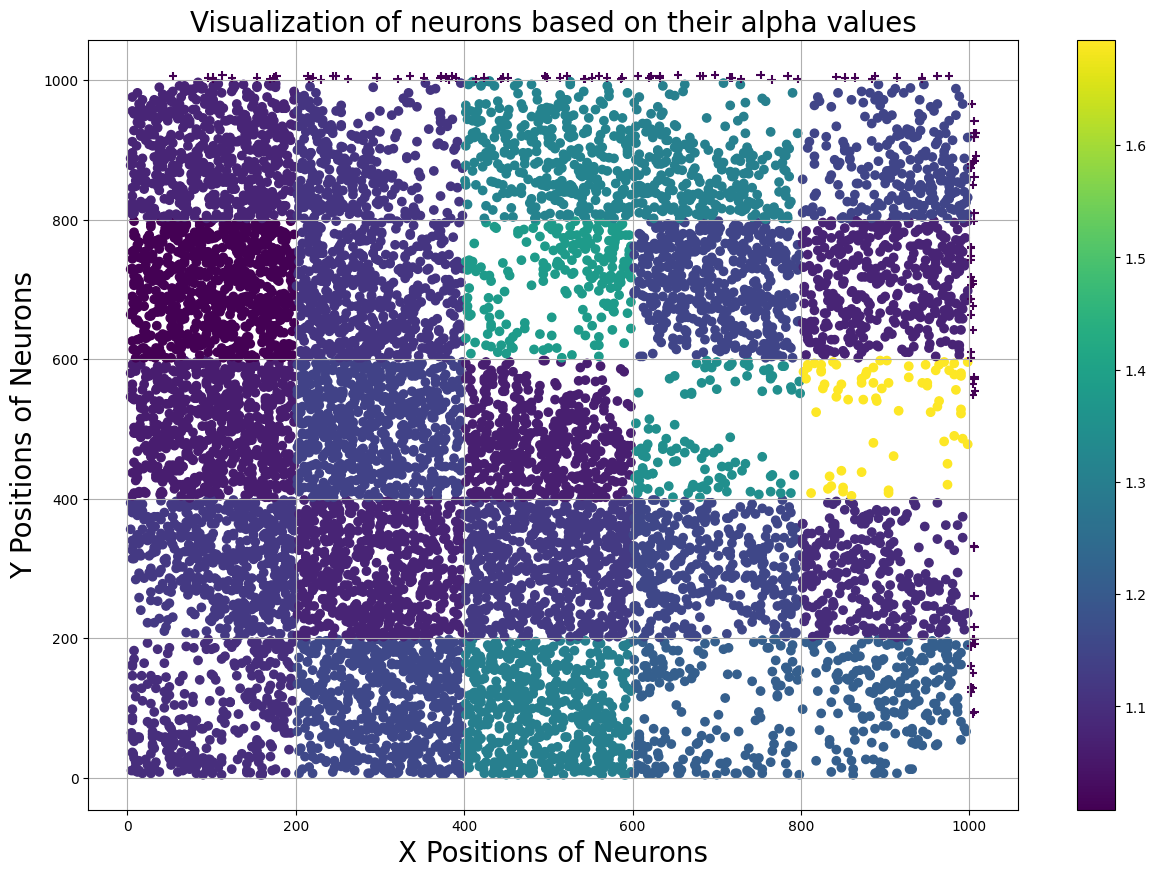

In [58]:

for i in range(36):
    if len(x[inxs[i]]) < 20:
         plt.scatter(x[inxs[i]], y[inxs[i]], marker='+',c=[jalpha[i]]*len(x[inxs[i]]), vmax=max(jalpha), vmin=min(jcp))
    else:
        plt.scatter(x[inxs[i]], y[inxs[i]], c=[jalpha[i]]*len(x[inxs[i]]), vmax=max(jalpha), vmin=min(jcp))
plt.colorbar()
plt.xlabel('X Positions of Neurons', fontsize=20)
plt.ylabel('Y Positions of Neurons', fontsize=20)
plt.xticks(np.arange(1008, step=200))
plt.yticks(np.arange(1008, step=200))
plt.grid(True)
plt.title("Visualization of neurons based on their alpha values", fontsize=20)

In [72]:
xs = [len(x[inxs[j]]) for j in range(36)] 

In [79]:
ys = [ a for _, a in sorted(zip(xs, jalpha)) if a > 0 ] 

In [82]:
xss = [x for x in xs if x> 20]

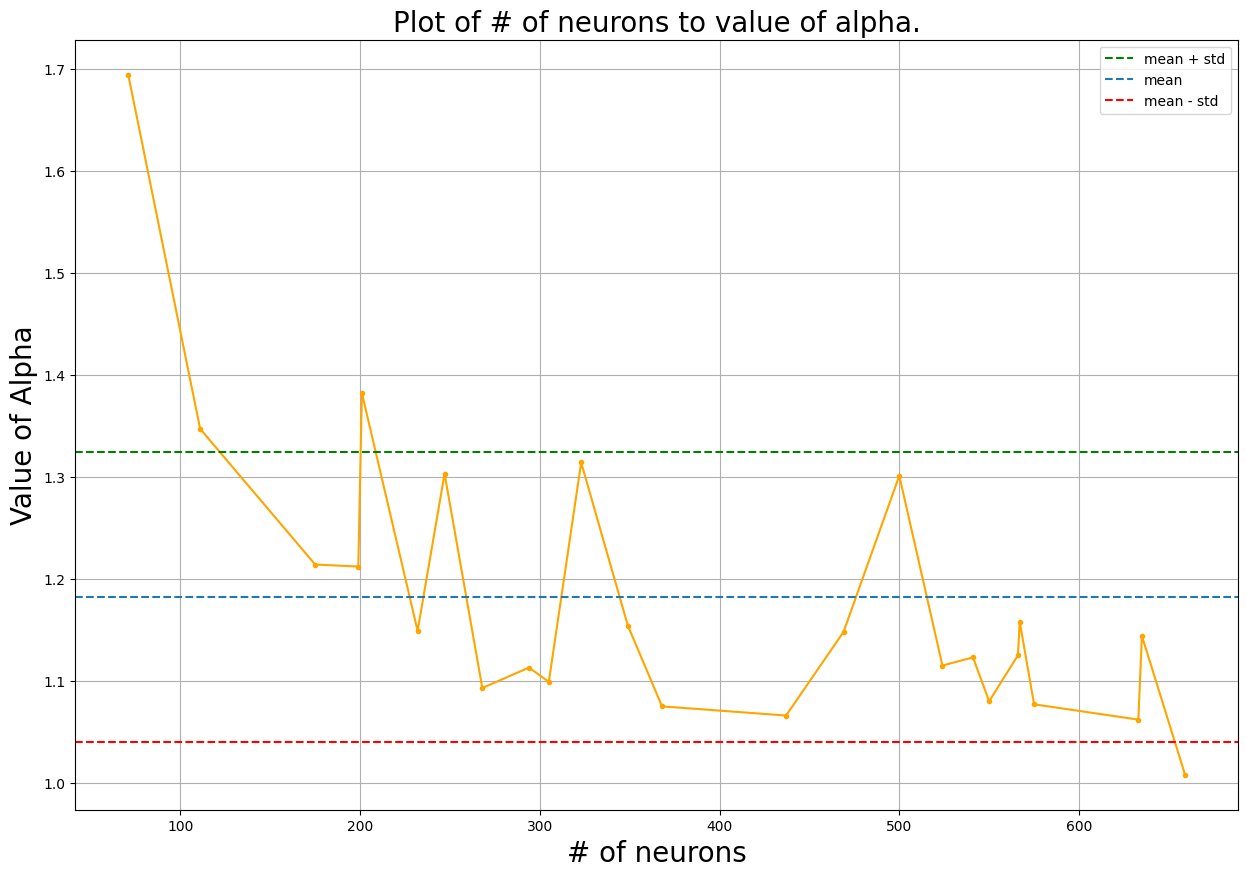

In [85]:

plt.plot(sorted(xss), ys, marker='.', color='orange')
plt.xlabel("# of neurons", fontsize=20)
plt.axhline(y=mean(ys) + std(ys), linestyle="--", color='green', label='mean + std')
plt.axhline(y=mean(ys), linestyle='--', label="mean")
plt.axhline(y=mean(ys) - std(ys), linestyle="--", color='red', label="mean - std")
plt.ylabel("Value of Alpha", fontsize=20)
plt.title("Plot of # of neurons to value of alpha.", fontsize=20)
plt.grid(True)
plt.legend()

In [ ]:
# compute alpha for random values of

In [ ]:
# compute alpha for random subpops of different sizes
# get different sizes from 70, 1000,
# get 10 diff random subpop of neurons of given size
# then compute alpha for subpop


In [112]:
sizes = np.arange(70, 1000, step=30)


In [113]:
sizes

array([ 70, 100, 130, 160, 190, 220, 250, 280, 310, 340, 370, 400, 430,
       460, 490, 520, 550, 580, 610, 640, 670, 700, 730, 760, 790, 820,
       850, 880, 910, 940, 970])

In [118]:
def get_rsamp(x, size=70):
    """Return sample of given size"""
    samp = random.sample(list(x[:, :, 0:10000].T), size)
    samp = np.asarray(samp).T
    print(shape)
    return samp

In [114]:
from tqdm import tqdm

In [ ]:
alpha_dict = dict()
for size in tqdm(sizes):
    alpha_list = []
    for _ in range(11):
        sample = get_rsamp(resp0, size=size)
        ss1 = compute_cvPCA(sample)
        a, _, _ = u.get_powerlaw(ss1, np.arange(5, 69).astype('int'))
        alpha_list.append(round(a, 3))
    alpha_dict[size] = alpha_list 


In [125]:
alpha_dict.values()

dict_values([[1.46, 1.062, 1.819, 1.421, 1.312, 1.331, 1.35, 1.208, 1.503, 1.649, 1.515], [1.116, 1.054, 1.219, 1.223, 1.209, 1.296, 1.298, 1.274, 1.086, 1.244, 0.989], [1.222, 1.08, 0.997, 0.972, 1.158, 1.061, 1.32, 0.969, 1.08, 1.148, 0.863], [1.108, 1.055, 0.99, 1.099, 0.917, 0.913, 1.084, 0.97, 1.052, 0.82, 1.324], [0.743, 1.205, 1.14, 1.044, 1.188, 1.264, 1.139, 1.297, 1.218, 1.117, 0.954], [0.764, 1.167, 1.237, 1.314, 1.265, 1.141, 0.998, 1.021, 0.967, 1.212, 0.946], [0.908, 1.057, 0.972, 0.954, 0.95, 1.085, 1.063, 1.084, 0.792, 0.834, 0.973], [0.985, 0.941, 0.841, 0.939, 0.981, 0.852, 1.17, 1.003, 1.05, 0.857, 1.046], [0.961, 0.9, 0.922, 0.924, 0.871, 0.779, 0.854, 0.939, 0.988, 0.912, 0.933], [0.958, 0.952, 0.964, 1.07, 0.825, 0.956, 1.087, 0.921, 0.997, 1.137, 0.888], [0.885, 0.902, 0.948, 0.905, 1.023, 0.946, 0.914, 0.867, 1.023, 1.007, 0.845], [0.925, 1.039, 0.931, 1.133, 0.843, 1.111, 0.819, 1.099, 0.956, 1.004, 0.896], [0.851, 0.961, 0.887, 0.983, 1.111, 0.985, 0.883, 0.84

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


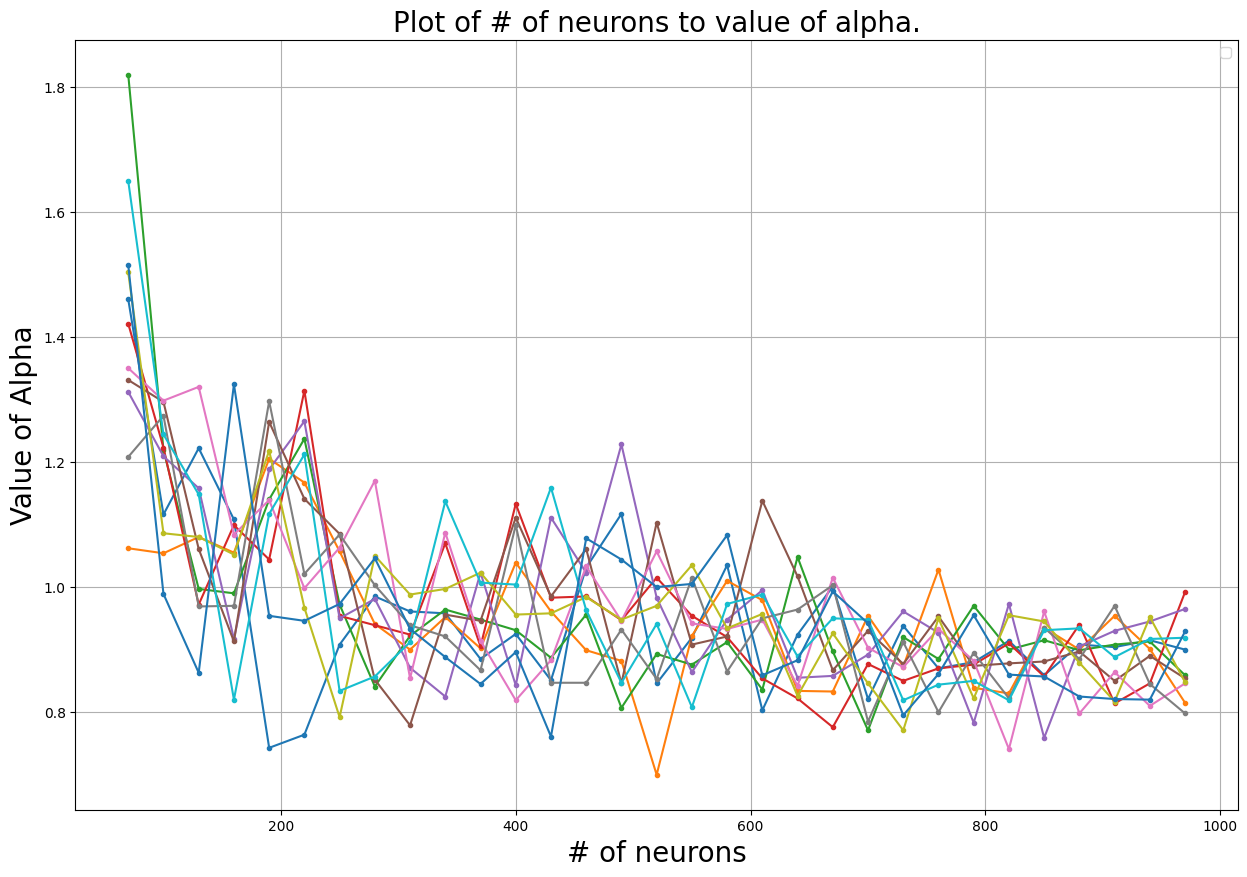

In [126]:

plt.plot(sizes, alpha_dict.values(), marker='.')
plt.xlabel("# of neurons", fontsize=20)
plt.ylabel("Value of Alpha", fontsize=20)
plt.title("Plot of # of neurons to value of alpha.", fontsize=20)
plt.grid(True)
plt.legend()


In [ ]:
plt.plot(sorted(xss), ys, marker='.', color='black')
plt.plot(sizes, alpha_dict.values(), marker='.')
plt.xlabel("# of neurons", fontsize=20)
plt.ylabel("Value of Alpha", fontsize=20)
plt.title("Plot of # of neurons to value of alpha.", fontsize=20)
plt.grid(True)
plt.legend()